In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from data.data_reader import DataReaderZarr
from batch.data_transforms.db_with_limits import db_with_limits
from tqdm import tqdm
plt.rcParams["axes.grid"] = False

/home/a39083/.virtualenvs/dino_plain/lib/python3.10/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
years = [2007,2008,2009,2010,2011,2013,2014,2015,2016,2017,2018]
year_codes = [2007205,2008205,2009107,2010205,2011206,2013842,2014807,2015837,2016837,2017843,2018823]
y = 9

survey_path = f'/scratch/disk5/ahmet/data/{years[y]}' #'/Users/apa055/Desktop/data'

surveys = [f'/{year_codes[y]}/ACOUSTIC/GRIDDED/{year_codes[y]}_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

survey = readers[0]
survey

In [3]:
prediction_2017 = xr.open_dataarray('/scratch/disk5/ahmet/data/UNET_Predictions/2017843_pred.zarr')

/home/a39083/.virtualenvs/dino_plain/lib/python3.10/site-packages/xarray/backends/plugins.py:118: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/a39083/.virtualenvs/dino_plain/lib/python3.10/site-packages/xarray/backends/plugins.py:118: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/a39083/.virtualenvs/dino_plain/lib/python3.10/site-packages/xarray/backends/plugins.py:118: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [3]:
def process_data(features):
    features[1].replace({'other_seabed': 'other', 'sandeel_seabed': 'sandeel', 'seabed': 'background'}, inplace=True)
    features.reset_index(drop=True, inplace=True)

    value = min(features[1].value_counts().get('other', 0), features[1].value_counts().get('sandeel', 0))

    np.random.seed(1)
    features = features.groupby(1, group_keys=False).apply(lambda x: x.sample(min(value, len(x)), replace=False))

    filtered_df = features[~features[1].isin(['other_seabed', 'sandeel_seabed', 'sandeel_other', 'sandeel_other_seabed'])]
    features = filtered_df.reset_index(drop=True)
    features.dropna(inplace=True)
    features = features.reset_index(drop=True)
    return features

In [4]:
features_DINO = pd.read_csv('/scratch/disk5/ahmet/dino_output/extracted_features/Undersampled_Patch_Array_Features/Model25_2017_8w.csv', header=None, sep=r',|\t', engine='python')

features_DINO=process_data(features_DINO)
features_DINO.iloc[:, 1].value_counts()

other         13806
background    13806
sandeel       13806
Name: 1, dtype: int64

In [5]:
# Defining The Data
features_predictions = features_DINO.drop(columns=features_DINO.columns[11:])
features_predictions

,0,1,2,3,4,5,6,7,8,9,10
0,32553,background,2017,108,683660,background,0,0,0,-70.413610,64
1,110637,background,2017,244,755476,seabed,0,0,37,-44.470948,64
2,107170,background,2017,252,531860,seabed,0,0,2,-74.653352,64
3,97162,background,2017,308,55588,seabed,0,0,12,-67.204659,64
4,121513,background,2017,492,1431444,seabed,0,0,2,-71.070074,64
...,...,...,...,...,...,...,...,...,...,...,...
41413,74484,sandeel,2017,180,1286588,sandeel,0,64,0,-66.796544,64
41414,55825,sandeel,2017,108,627308,sandeel,0,64,0,-72.084950,64
41415,61901,sandeel,2017,76,77900,sandeel,0,64,0,-62.776441,64
41416,80479,sandeel,2017,68,677164,sandeel,0,54,0,-71.615718,64


In [9]:
frequencies = [18, 38, 120, 200]
window_size = [8, 8]
#print(len(filtered_rows))
ping_extend = 0

i=0
new_columns = ['other' + str(i) if i < 64 else 'sandeel' + str(i-64) for i in range(128)]
features_predictions[new_columns] = np.nan

for i in tqdm(range(len(features_predictions)), desc="Processing rows"):
    row = features_predictions.iloc[i]
    ping_start = row[4] - window_size[0] // 2 - ping_extend
    ping_end = row[4] + window_size[0] // 2 + ping_extend
    range_start = max(row[3] - window_size[0] // 2 - ping_extend, 0)
    range_end = row[3] + window_size[0] // 2 + ping_extend
    ping_slice, range_slice = slice(ping_start, ping_end), slice(range_start, range_end)
    
    pred_values_1_27 = prediction_2017.sel(category=[1,27]).isel(ping_time=ping_slice, range=range_slice).values.flatten()
    features_predictions.loc[i, new_columns] = pred_values_1_27

Processing rows: 100%|██████████| 41418/41418 [23:14<00:00, 29.70it/s]


In [10]:
features_predictions.to_csv('unet_predictions.csv', index=False)

In [6]:
unet_predictions = pd.read_csv('unet_predictions.csv')

In [16]:
import pandas as pd
import numpy as np

softmax_columns = unet_predictions.columns[10:]

class_labels = np.empty((unet_predictions.shape[0], 64), dtype='object')

for i in range(64):
    other_column = softmax_columns[i]
    sandeel_column = softmax_columns[i + 64]

    other_softmax_values = unet_predictions[other_column].values
    sandeel_softmax_values = unet_predictions[sandeel_column].values

    max_value_index = np.argmax([other_softmax_values, sandeel_softmax_values], axis=0)
    class_labels[:, i] = np.where(max_value_index == 1, 'sandeel', 'other')
    class_labels[np.max([other_softmax_values, sandeel_softmax_values], axis=0) < 0.333333, i] = 'background'

unet_predictions['sandeel_pixels'] = np.sum(class_labels == 'sandeel', axis=1)
unet_predictions['other_pixels'] = np.sum(class_labels == 'other', axis=1)
unet_predictions['background_pixels'] = np.sum(class_labels == 'background', axis=1)


Root Mean Squared Error (RMSE) on the test set: 8.84
R-squared on the test set: 0.76
Mean Absolute Error (MAE) on the test set: 3.39


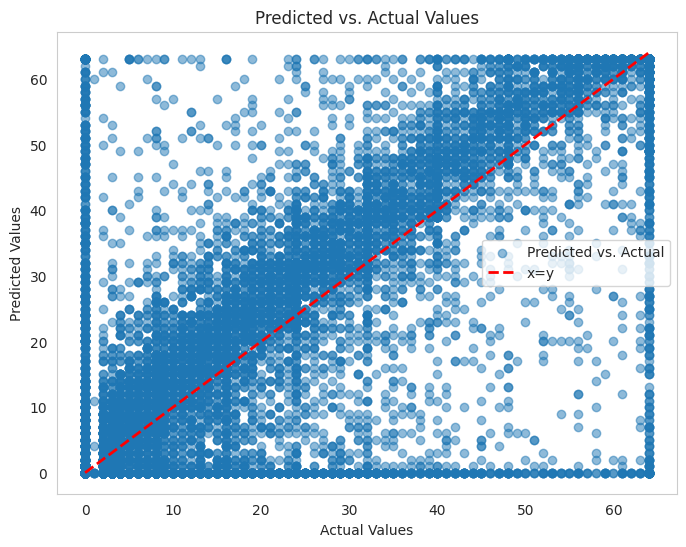

In [17]:
from sklearn.metrics import r2_score, mean_absolute_error
from skimage.metrics import mean_squared_error
import numpy as np

sandeel_softmax_columns = unet_predictions.columns[74:138]

threshold = 0.8681640625 #maximizing F1 score

unet_predictions['sandeel_pixels'] = np.sum(unet_predictions[sandeel_softmax_columns] > threshold, axis=1)

rmse = np.sqrt(mean_squared_error(unet_predictions.iloc[:,7], unet_predictions.iloc[:,139]))
print(f'Root Mean Squared Error (RMSE) on the test set: {rmse:.2f}')

r2 = r2_score(unet_predictions.iloc[:,7], unet_predictions.iloc[:,139])
print(f'R-squared on the test set: {r2:.2f}')

mae = mean_absolute_error(unet_predictions.iloc[:,7], unet_predictions.iloc[:,139])
print(f'Mean Absolute Error (MAE) on the test set: {mae:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(unet_predictions.iloc[:,7], unet_predictions.iloc[:,139], alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(unet_predictions.iloc[:,7]), max(unet_predictions.iloc[:,7])], [min(unet_predictions.iloc[:,7]), max(unet_predictions.iloc[:,7])], color='red', linestyle='--', linewidth=2, label='x=y')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


In [22]:
y

,0,1,2,3,4,5,6,7,8,9,...,sandeel57,sandeel58,sandeel59,sandeel60,sandeel61,sandeel62,sandeel63,sandeel_pixels,other_pixels,background_pixels
0,32553,background,2017,108,683660,background,0,0,0,-70.413610,...,0.000101,0.000121,0.000203,0.000260,2.756119e-04,0.000311,0.000298,0,1,63
1,110637,background,2017,244,755476,seabed,0,0,37,-44.470948,...,0.002407,0.002707,0.005890,0.000008,8.344650e-07,0.000009,0.000048,0,1,63
2,107170,background,2017,252,531860,seabed,0,0,2,-74.653352,...,0.000017,0.000018,0.000031,0.000086,4.670620e-04,0.003952,0.033081,0,1,62
3,97162,background,2017,308,55588,seabed,0,0,12,-67.204659,...,0.000045,0.000048,0.000053,0.000266,1.133919e-03,0.013153,0.025940,0,1,63
4,121513,background,2017,492,1431444,seabed,0,0,2,-71.070074,...,0.000006,0.000017,0.000014,0.000035,2.354383e-05,0.000092,0.000086,0,4,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41413,74484,sandeel,2017,180,1286588,sandeel,0,64,0,-66.796544,...,0.894043,0.872559,0.911621,0.916016,9.345703e-01,0.940430,0.943848,41,1,0
41414,55825,sandeel,2017,108,627308,sandeel,0,64,0,-72.084950,...,0.988770,0.992188,0.992676,0.993652,9.931641e-01,0.994141,0.993652,63,1,0
41415,61901,sandeel,2017,76,77900,sandeel,0,64,0,-62.776441,...,0.965820,0.975098,0.983398,0.985352,9.848633e-01,0.982422,0.979004,63,1,0
41416,80479,sandeel,2017,68,677164,sandeel,0,54,0,-71.615718,...,0.964355,0.963867,0.965332,0.965820,9.663086e-01,0.967773,0.967773,59,1,0


In [20]:
from sklearn.model_selection import train_test_split

X = unet_predictions.iloc[:,8]
y = unet_predictions.iloc[:,6:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [21]:

rmse = np.sqrt(mean_squared_error(y_test.iloc[:,1], y_test.iloc[:,133]))
print(f'Root Mean Squared Error (RMSE) on the test set: {rmse:.2f}')

r2 = r2_score(y_test.iloc[:,1], y_test.iloc[:,133])
print(f'R-squared on the test set: {r2:.2f}')
mae = mean_absolute_error(y_test.iloc[:,1], y_test.iloc[:,133])
print(f'Mean Absolute Error (MAE) on the test set: {mae:.2f}')

plt.figure(figsize=(7, 6))
plt.scatter(y_test.iloc[:,1], y_test.iloc[:,133], alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(y_test.iloc[:,1]), max(y_test.iloc[:,1])], [min(y_test.iloc[:,1]), max(y_test.iloc[:,1])], color='red', linestyle='--', linewidth=2, label='x=y')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

IndexingError: Too many indexers

In [11]:
len(X_selected)

13009

Root Mean Squared Error (RMSE) on the test set: 14.01
R-squared on the test set: 0.57
Mean Absolute Error (MAE) on the test set: 8.95


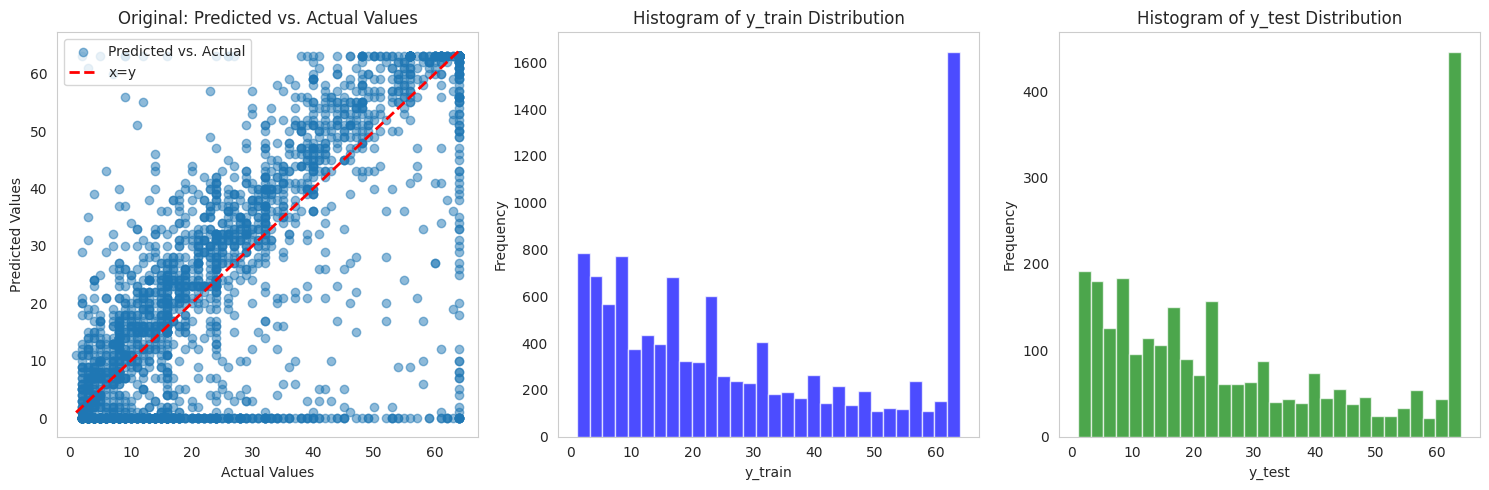

In [7]:
# Undersampled Classes

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
X = unet_predictions.iloc[:,10] 
y = unet_predictions.iloc[:,7] 

zero_indices = y[y == 0].index

random_indices = np.random.choice(zero_indices, size=0, replace=False)

non_zero_indices = y[y != 0].index

selected_indices = np.concatenate([random_indices, non_zero_indices])

X_selected = X.loc[selected_indices]
y_selected = y.loc[selected_indices]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.20, random_state=42)


y_pred = unet_predictions.loc[y_test.index].iloc[:,139]

y_pred = np.maximum(y_pred, 0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE) on the test set: {rmse:.2f}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared on the test set: {r2:.2f}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE) on the test set: {mae:.2f}')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='x=y')
plt.title('Original: Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(y_train, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of y_train Distribution')
plt.xlabel('y_train')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(y_test, bins=30, color='green', alpha=0.7)
plt.title('Histogram of y_test Distribution')
plt.xlabel('y_test')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [23]:
# Assigning UNET PREDICTION CLASSES


unet_predictions['Unet_classes'] = 'background' 

unet_predictions.loc[unet_predictions['sandeel_pixels'] >= 2, 'Unet_classes'] = 'sandeel'
unet_predictions.loc[unet_predictions['other_pixels'] >= 2, 'Unet_classes'] = 'other'

unet_predictions

,0,1,2,3,4,5,6,7,8,9,...,sandeel58,sandeel59,sandeel60,sandeel61,sandeel62,sandeel63,sandeel_pixels,other_pixels,background_pixels,Unet_classes
0,32553,background,2017,108,683660,background,0,0,0,-70.413610,...,0.000121,0.000203,0.000260,2.756119e-04,0.000311,0.000298,0,1,63,background
1,110637,background,2017,244,755476,seabed,0,0,37,-44.470948,...,0.002707,0.005890,0.000008,8.344650e-07,0.000009,0.000048,0,1,63,background
2,107170,background,2017,252,531860,seabed,0,0,2,-74.653352,...,0.000018,0.000031,0.000086,4.670620e-04,0.003952,0.033081,0,1,62,background
3,97162,background,2017,308,55588,seabed,0,0,12,-67.204659,...,0.000048,0.000053,0.000266,1.133919e-03,0.013153,0.025940,0,1,63,background
4,121513,background,2017,492,1431444,seabed,0,0,2,-71.070074,...,0.000017,0.000014,0.000035,2.354383e-05,0.000092,0.000086,0,4,60,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41413,74484,sandeel,2017,180,1286588,sandeel,0,64,0,-66.796544,...,0.872559,0.911621,0.916016,9.345703e-01,0.940430,0.943848,41,1,0,sandeel
41414,55825,sandeel,2017,108,627308,sandeel,0,64,0,-72.084950,...,0.992188,0.992676,0.993652,9.931641e-01,0.994141,0.993652,63,1,0,sandeel
41415,61901,sandeel,2017,76,77900,sandeel,0,64,0,-62.776441,...,0.975098,0.983398,0.985352,9.848633e-01,0.982422,0.979004,63,1,0,sandeel
41416,80479,sandeel,2017,68,677164,sandeel,0,54,0,-71.615718,...,0.963867,0.965332,0.965820,9.663086e-01,0.967773,0.967773,59,1,0,sandeel


Accuracy: 82.8827%


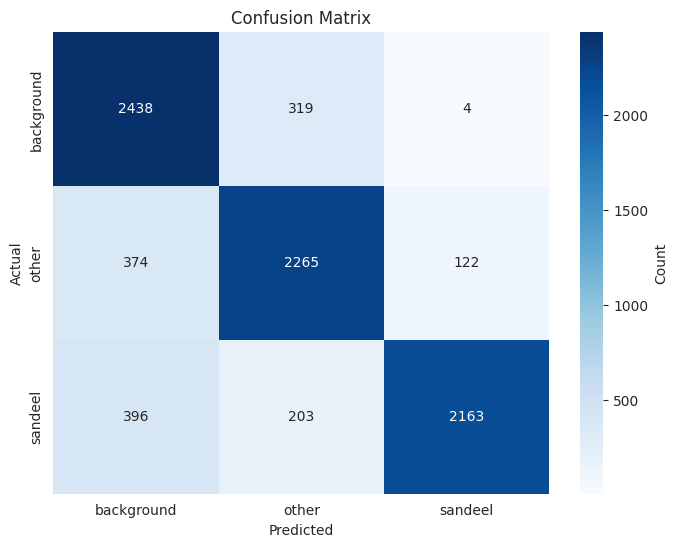

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

train_data, test_data = train_test_split(unet_predictions, test_size=0.2, random_state=42, stratify=unet_predictions.iloc[:,1])

y_true = test_data['1']
y_pred = test_data['Unet_classes']

class_labels = ['background', 'other', 'sandeel']

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4%}")

conf_matrix = confusion_matrix(y_true, y_pred, labels=class_labels)
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [10]:
(2486+2284+2143)/(2486+2284+2143+313+3+347+139+354+215)

0.8345002414292613